# <center> 2. Descriptive Analysis

In [44]:
# importing required libraries
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

#### 1. Importing the cleaned data from the file into a dataframe.

In [15]:
dfT1DData = pd.read_excel("../SourceData/Processed/Team10_PythonWranglers_CleanedData.xlsx")

#### 1. What is the demographic breakdown of patients?

#### *Reasoning: Understanding the breakdown of patients especially with respect to age and gender can gibe us a better understanding of the data and help us analysis.*

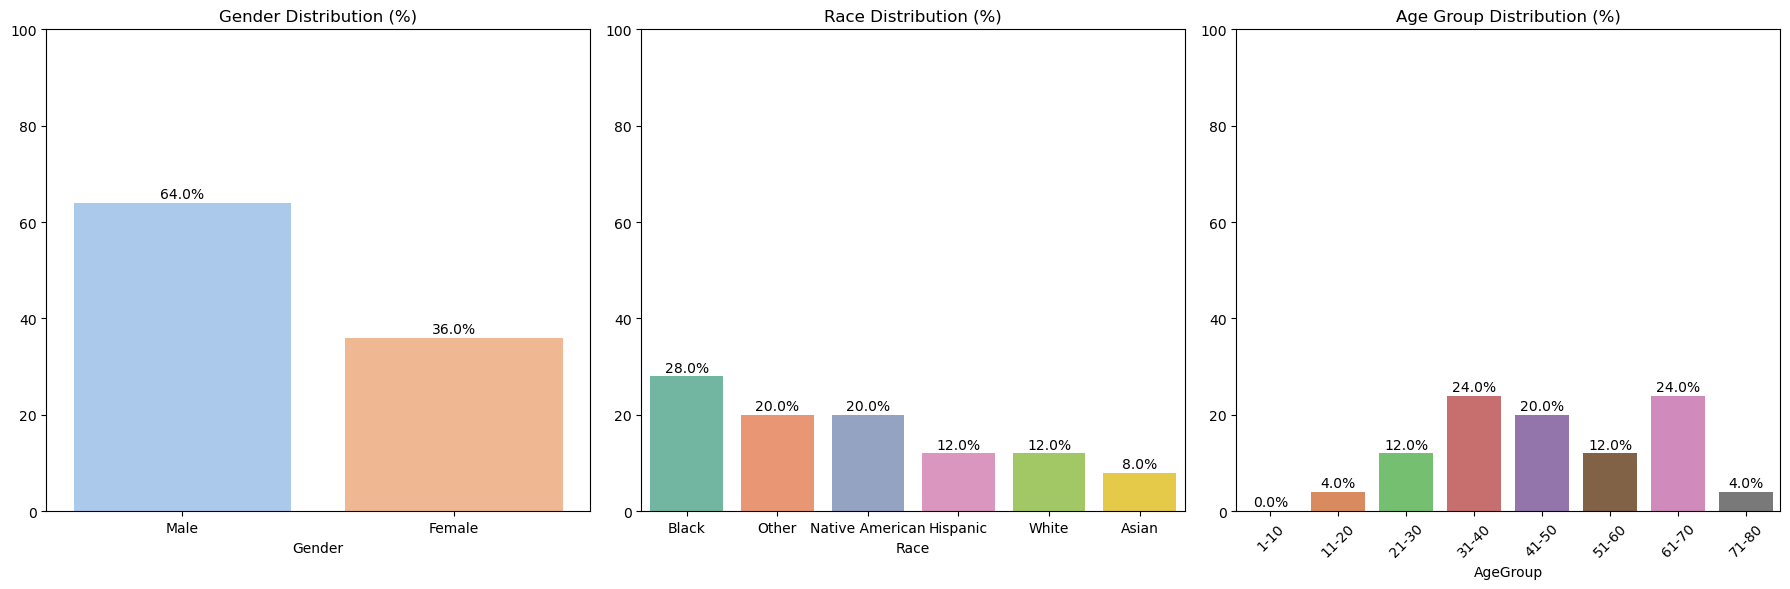

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Collapse to unique patients and rename to dfDemographicsData ---
dfDemographicsData = dfT1DData[['patient_id', 'Age', 'Gender', 'Race']].drop_duplicates()

# --- Create 10-year age groups starting at 1 ---
bins = range(1, dfDemographicsData['Age'].max() + 10, 10)
labels = [f"{i}-{i+9}" for i in bins[:-1]]
dfDemographicsData['AgeGroup'] = pd.cut(dfDemographicsData['Age'], bins=bins, labels=labels, right=True)

# --- Calculate percentages ---
gender_counts = dfDemographicsData['Gender'].value_counts(normalize=True) * 100
race_counts = dfDemographicsData['Race'].value_counts(normalize=True) * 100
age_counts = dfDemographicsData['AgeGroup'].value_counts(normalize=True).sort_index() * 100

# --- Plot side-by-side ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender
sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[0], palette="pastel")
axes[0].set_title("Gender Distribution (%)")
axes[0].set_ylim(0, 100)  # standardize to percentage scale
for i, v in enumerate(gender_counts.values):
    axes[0].text(i, v + 1, f"{v:.1f}%", ha='center')

# Race
sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], palette="Set2")
axes[1].set_title("Race Distribution (%)")
axes[1].set_ylim(0, 100)
for i, v in enumerate(race_counts.values):
    axes[1].text(i, v + 1, f"{v:.1f}%", ha='center')

# Age groups
sns.barplot(x=age_counts.index, y=age_counts.values, ax=axes[2], palette="muted")
axes[2].set_title("Age Group Distribution (%)")
axes[2].set_ylim(0, 100)
axes[2].tick_params(axis='x', rotation=45)
for i, v in enumerate(age_counts.values):
    axes[2].text(i, v + 1, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.show()

#### 2. What is the average blood glucose level of all patients, and how much time do they spend within target range (70 - 180 mg/dL), below 70 (hypoglycemia) and above 180 (hyperglycemia)?

#### *Reasoning: Understanding the average blood glucose values of each patient as well as the amount of time they are spending in range will help guide our analysis.*


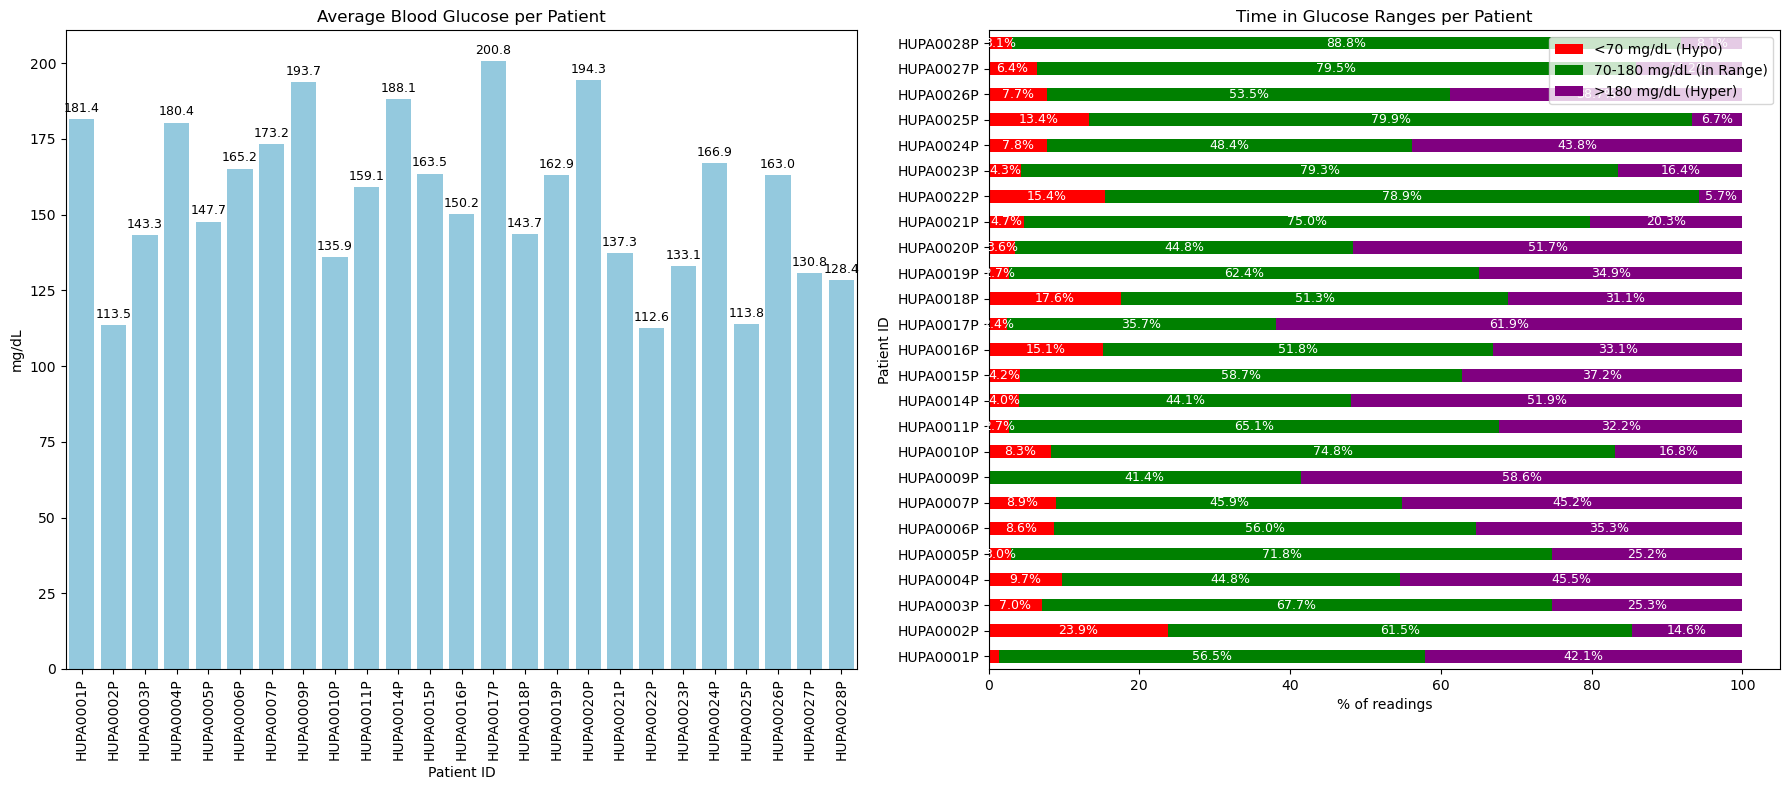

In [38]:
# --- Step 1: Calculate metrics per patient ---
results = []

for pid, group in dfT1DData.groupby('patient_id'):
    avg_glucose = group['glucose'].mean()
    total = len(group)
    
    time_in_range = (group['glucose'].between(70, 180)).sum() / total * 100
    time_below = (group['glucose'] < 70).sum() / total * 100
    time_above = (group['glucose'] > 180).sum() / total * 100
    
    results.append({
        'patient_id': pid,
        'avg_glucose': avg_glucose,
        'time_below_%': time_below,
        'time_in_range_%': time_in_range,
        'time_above_%': time_above
    })

df_metrics = pd.DataFrame(results)

# --- Step 2: Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# --- Left Chart: Average Glucose per Patient ---
sns.barplot(x='patient_id', y='avg_glucose', data=df_metrics,
            ax=axes[0], color='skyblue')

# Add labels on bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_height(), '.1f'),  
                     (p.get_x() + p.get_width() / 2., p.get_height()),  
                     ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

axes[0].set_title("Average Blood Glucose per Patient")
axes[0].set_ylabel("mg/dL")
axes[0].set_xlabel("Patient ID")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=90)

# --- Right Chart: Stacked Horizontal Bar for Time in Ranges ---
stacked_data = df_metrics.set_index('patient_id')[['time_below_%', 'time_in_range_%', 'time_above_%']]

colors = ['red', 'green', 'purple']
stacked_data.plot(kind='barh', stacked=True, ax=axes[1], color=colors)

# Add labels on each segment
for i, patient in enumerate(stacked_data.index):
    left = 0
    for j, col in enumerate(stacked_data.columns):
        width = stacked_data.loc[patient, col]
        if width > 2:  # only label if segment is wide enough
            axes[1].text(left + width/2, i, f'{width:.1f}%', ha='center', va='center', color='white', fontsize=9)
        left += width

axes[1].set_xlabel("% of readings")
axes[1].set_ylabel("Patient ID")
axes[1].set_title("Time in Glucose Ranges per Patient")
axes[1].legend(['<70 mg/dL (Hypo)', '70-180 mg/dL (In Range)', '>180 mg/dL (Hyper)'], loc='upper right')

plt.tight_layout()
plt.show()

#### 3. What is the distribution of glucose readings (minimum, maximum, median, mean, standard deviation) showing how stable or variable their sugars are?

#### *Reasoning: Understanding the glucose profiles of participants is essential to the analysis.*

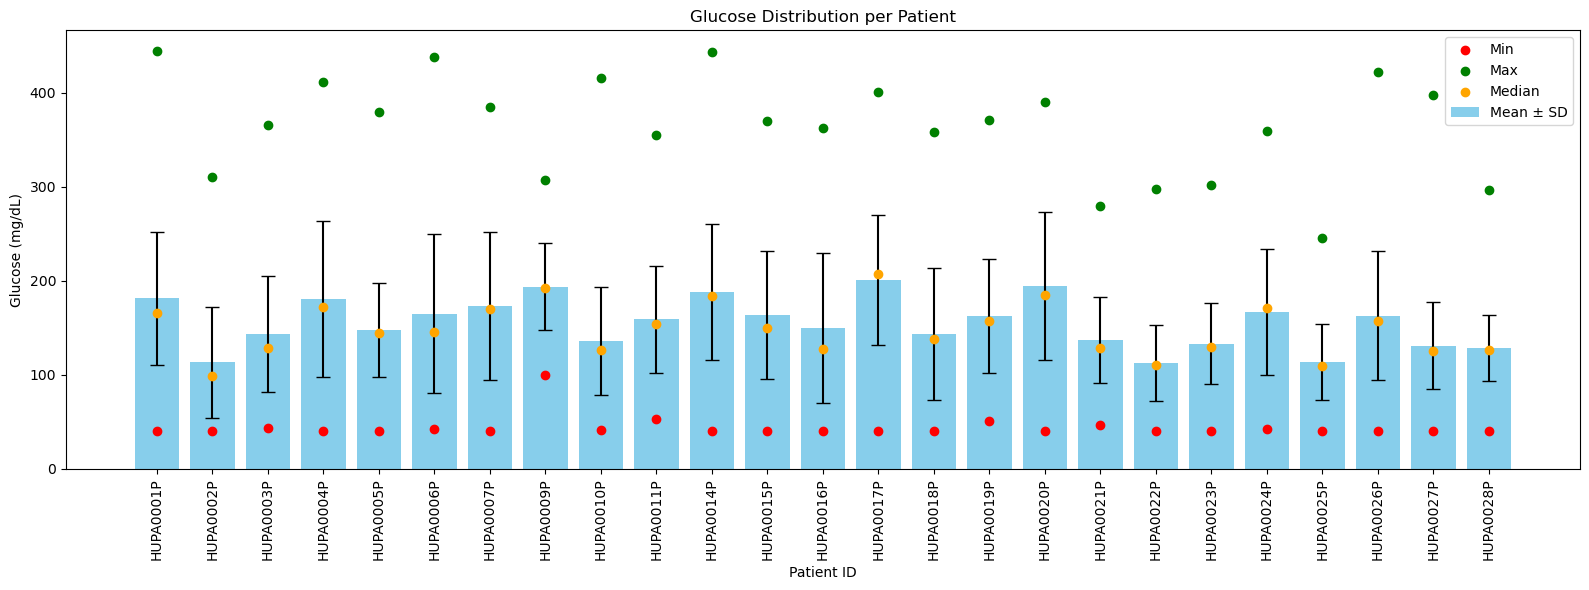

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Step 1: Calculate summary statistics per patient ---
summary_stats = dfT1DData.groupby('patient_id')['glucose'].agg(['min', 'max', 'mean', 'median', 'std']).reset_index()

# --- Step 2: Plot ---
fig, ax = plt.subplots(figsize=(16, 6))

# Bar for mean glucose
ax.bar(summary_stats['patient_id'], summary_stats['mean'], yerr=summary_stats['std'], capsize=5, color='skyblue', label='Mean ± SD')

# Overlay min, max, median as points
ax.scatter(summary_stats['patient_id'], summary_stats['min'], color='red', label='Min', zorder=5)
ax.scatter(summary_stats['patient_id'], summary_stats['max'], color='green', label='Max', zorder=5)
ax.scatter(summary_stats['patient_id'], summary_stats['median'], color='orange', label='Median', zorder=5)

# Decorations
ax.set_xlabel("Patient ID")
ax.set_ylabel("Glucose (mg/dL)")
ax.set_title("Glucose Distribution per Patient")
ax.set_xticklabels(summary_stats['patient_id'], rotation=90)
ax.legend()

plt.tight_layout()
plt.show()

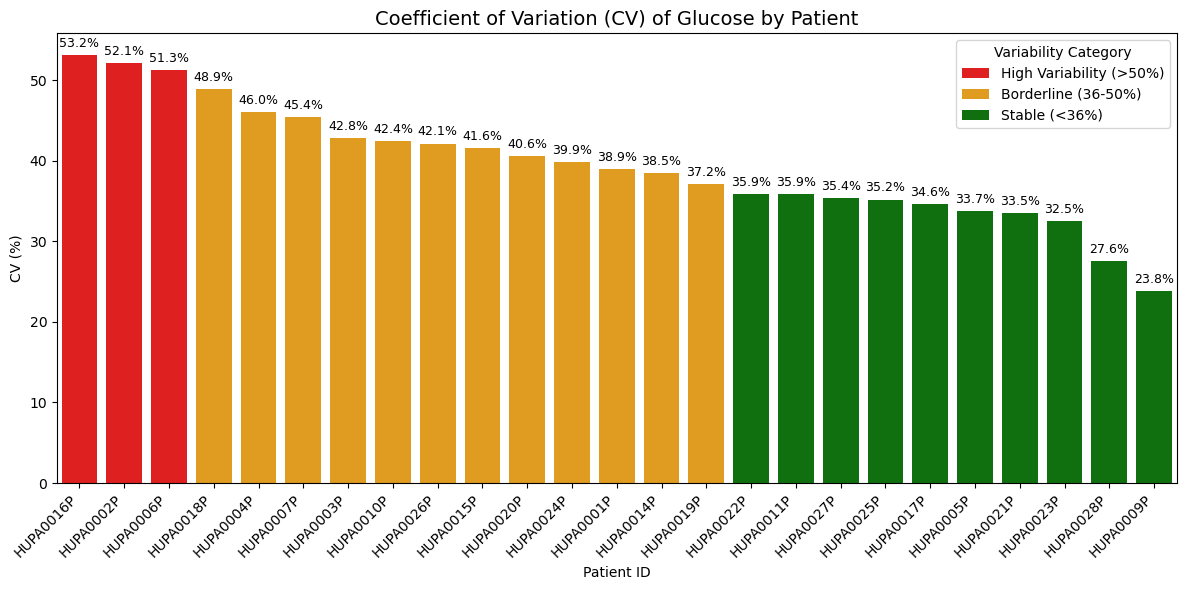

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Calculate Mean, SD, and CV per patient ---
df_variability = dfT1DData.groupby("patient_id")['glucose'].agg(['mean', 'std']).reset_index()
df_variability['CV'] = (df_variability['std'] / df_variability['mean']) * 100

# --- Step 2: Define categories for CV ---
def cv_category(cv):
    if cv < 36:
        return "Stable (<36%)"
    elif cv < 50:
        return "Borderline (36-50%)"
    else:
        return "High Variability (>50%)"

df_variability['CV_Category'] = df_variability['CV'].apply(cv_category)

# --- Step 3: Sort by CV ---
df_variability = df_variability.sort_values(by='CV', ascending=False)

# --- Step 4: Plot ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_variability,
    x='patient_id',
    y='CV',
    hue='CV_Category',
    dodge=False,
    palette={'Stable (<36%)': 'green', 
             'Borderline (36-50%)': 'orange', 
             'High Variability (>50%)': 'red'}
)

# Add labels on bars
for i, v in enumerate(df_variability['CV']):
    plt.text(i, v + 1, f"{v:.1f}%", ha='center', fontsize=9)

plt.title("Coefficient of Variation (CV) of Glucose by Patient", fontsize=14)
plt.xlabel("Patient ID")
plt.ylabel("CV (%)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Variability Category")
plt.tight_layout()
plt.show()